In [1]:
from fredapi import Fred
from scipy.optimize import fsolve
from sequence_jacobian import simple, create_model
from sequence_jacobian.utilities.drawdag import drawdag
from statsmodels.tsa.filters.hp_filter import hpfilter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fred = Fred(api_key = 'f6fa4f544be19c2ea791e9a3240470bf')

# Question 1

### Part 1

In [3]:
# function for returning HP-filtered logged data series
def get_detrended_data(start_date, end_date, monthly_end_date, lamb):
    
    Y = fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)
    Y_log = np.log(fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)) * 100

    # deflator for consumption series
    defl = fred.get_series('PCECTPI', observation_start = start_date, observation_end = end_date)

    # convert nominal consumption series to real
    C_log = np.log(fred.get_series('PCEC', observation_start = start_date, 
                                   observation_end = end_date) / defl) * 100
    Cd_log = np.log(fred.get_series('PCDG', observation_start = start_date, 
                                    observation_end = end_date) / defl) * 100
    Cn_log = np.log(fred.get_series('PCND', observation_start = start_date, 
                                    observation_end = end_date) / defl) * 100

    I_log = np.log(fred.get_series('GPDIC1', observation_start = start_date, observation_end = end_date)) * 100
    G_log = np.log(fred.get_series('GCEC1', observation_start = start_date, observation_end = end_date)) * 100

    # total hours = weekly hours * employment
    H = fred.get_series('PRS85006023', observation_start = start_date, observation_end = end_date)
    E = fred.get_series('PAYEMS', observation_start = start_date, observation_end = monthly_end_date)
    E_quarterly = np.mean(np.reshape(E, (3, len(E) // 3), order = 'F'), axis = 0)
    E_log = np.log(E_quarterly) * 100
    N_log = np.log(H * E_quarterly) * 100

    YN_log = np.log(Y / H) * 100

    # convert nominal wages to real
    w_log = np.log(fred.get_series('COMPNFB', observation_start = start_date, 
                                   observation_end = end_date) / defl) * 100

    # real interest rate = federal funds rate - realized inflation
    ffr = fred.get_series('FEDFUNDS', observation_start = start_date, observation_end = monthly_end_date)
    ffr_quarterly = np.mean(np.reshape(ffr, (3, len(ffr) // 3), order = 'F'), axis = 0)
    r = ffr_quarterly[1:] - (np.diff(np.log(defl)) * 100)
    
    output = [Y_log, C_log, Cd_log, Cn_log, I_log, G_log, N_log, YN_log, E_log, w_log]
    
    # detrend everything except for r using HP filter
    for i in range(len(output)):
        output[i] = hpfilter(output[i], lamb = lamb)[0]
    
    return output, r

In [4]:
# 1959Q1 to 2019Q4
[Y_trunc, C_trunc, Cd_trunc, Cn_trunc, I_trunc, 
 G_trunc, N_trunc, YN_trunc, E_trunc, w_trunc], r_trunc = get_detrended_data('1959-01-01', '2019-10-01', 
                                                                             '2019-12-01', 1600)
output_trunc = {'Y_trunc': Y_trunc, 
                'C_trunc': C_trunc, 
                'Cd_trunc': Cd_trunc,
                'Cn_trunc': Cn_trunc, 
                'I_trunc': I_trunc, 
                'G_trunc': G_trunc, 
                'N_trunc': N_trunc, 
                'Y/N_trunc': YN_trunc, 
                'E_trunc': E_trunc, 
                'w_trunc': w_trunc, 
                'r_trunc': r_trunc}

# bonus: 1959Q1 to 2021Q4
[Y, C, Cd, Cn, I, G, N, YN, E, w], r = get_detrended_data('1959-01-01', '2021-10-01', '2021-12-01', 1600)
output = {'Y': Y, 
          'C': C, 
          'Cd': Cd, 
          'Cn': Cn, 
          'I': I, 
          'G': G, 
          'N': N, 
          'Y/N': YN, 
          'E': E, 
          'w': w, 
          'r': r}

In [5]:
# standard deviation
stdev_trunc = {}
for key in output_trunc:
    stdev_trunc[key] = np.std(output_trunc[key])
    print(key, ': ', round(stdev_trunc[key], 4), sep = '')
print()
stdev = {}
for key in output:
    stdev[key] = np.std(output[key])
    print(key, ': ', round(stdev[key], 4), sep = '')

Y_trunc: 1.4307
C_trunc: 1.1531
Cd_trunc: 4.176
Cn_trunc: 1.4061
I_trunc: 6.45
G_trunc: 1.4968
N_trunc: 1.5416
Y/N_trunc: 1.1435
E_trunc: 1.2553
w_trunc: 0.9018
r_trunc: 3.2153

Y: 1.5532
C: 1.3841
Cd: 4.4052
Cn: 1.5129
I: 6.4757
G: 1.4852
N: 1.7764
Y/N: 1.2412
E: 1.4802
w: 0.9966
r: 3.2771


In [6]:
# relative standard deviation with respect to output
for key in output_trunc:
    print(key, ': ', round(stdev_trunc[key] / stdev_trunc['Y_trunc'], 4), sep = '')
print()
for key in output:
    print(key, ': ', round(stdev[key] / stdev['Y'], 4), sep = '')

Y_trunc: 1.0
C_trunc: 0.806
Cd_trunc: 2.9189
Cn_trunc: 0.9828
I_trunc: 4.5084
G_trunc: 1.0463
N_trunc: 1.0775
Y/N_trunc: 0.7993
E_trunc: 0.8774
w_trunc: 0.6304
r_trunc: 2.2474

Y: 1.0
C: 0.8911
Cd: 2.8362
Cn: 0.974
I: 4.1693
G: 0.9562
N: 1.1437
Y/N: 0.7991
E: 0.953
w: 0.6416
r: 2.1099


In [7]:
# first-order autocorrelation
for key in output_trunc:
    print(key, ': ', round(np.corrcoef(output_trunc[key][1:], 
                                       output_trunc[key][0:-1])[0, 1], 4), sep = '')
print()
for key in output:
    print(key, ': ', round(np.corrcoef(output[key][1:], output[key][0:-1])[0, 1], 4), sep = '')

Y_trunc: 0.8639
C_trunc: 0.8748
Cd_trunc: 0.7883
Cn_trunc: 0.8238
I_trunc: 0.8243
G_trunc: 0.8389
N_trunc: 0.9221
Y/N_trunc: 0.8422
E_trunc: 0.943
w_trunc: 0.6995
r_trunc: 0.9604

Y: 0.7684
C: 0.7189
Cd: 0.7742
Cn: 0.7617
I: 0.8021
G: 0.8331
N: 0.7819
Y/N: 0.746
E: 0.7839
w: 0.6636
r: 0.9624


In [8]:
# contemporaneous correlation with output
for key in output_trunc:
    if key == 'r_trunc':
        print(key, ': ', round(np.corrcoef(output_trunc[key], output_trunc['Y_trunc'][1:])[0, 1], 4), sep = '')
    else:
        print(key, ': ', round(np.corrcoef(output_trunc[key], output_trunc['Y_trunc'])[0, 1], 4), sep = '')
print()
for key in output:
    if key == 'r':
        print(key, ': ', round(np.corrcoef(output[key], output['Y'][1:])[0, 1], 4), sep = '')
    else:
        print(key, ': ', round(np.corrcoef(output[key], output['Y'])[0, 1], 4), sep = '')

Y_trunc: 1.0
C_trunc: 0.873
Cd_trunc: 0.7693
Cn_trunc: 0.6668
I_trunc: 0.9018
G_trunc: -0.0069
N_trunc: 0.8749
Y/N_trunc: 0.9492
E_trunc: 0.7993
w_trunc: 0.0862
r_trunc: 0.1827

Y: 1.0
C: 0.8867
Cd: 0.702
Cn: 0.6863
I: 0.8814
G: -0.0499
N: 0.8895
Y/N: 0.9564
E: 0.8202
w: -0.1063
r: 0.1655


### Part 2

In [9]:
def get_data(start_date, end_date):
    
    # real GDP
    Y = fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)
    
    # deflator for consumption series
    defl_c = fred.get_series('PCECTPI', observation_start = start_date, observation_end = end_date)
    
    # deflate housing
    H = fred.get_series('DHUTRC1Q027SBEA', observation_start = start_date, 
                        observation_end = end_date) / defl_c * 100
    
    # real government expenditures
    G = fred.get_series('GCEC1', observation_start = start_date, observation_end = end_date)
    
    # real private output
    Y_private = Y - H - G
    
    # deflator for investment series
    defl_i = fred.get_series('A008RD3Q086SBEA', observation_start = start_date, observation_end = end_date)
    
    # private investment (no housing) - de-annualize and deflate private investment
    I = fred.get_series('PNFI', observation_start = start_date, observation_end = end_date) / 4 / defl_i * 100
    
    # annual private capital stock (no housing)
    K = fred.get_series('K1NTOTL1ES000', observation_start = start_date, observation_end = end_date)
    
    # annualize investment deflator
    annual_delf_i = np.mean(np.reshape(defl_i, (4, len(defl_i) // 4), order = 'F'), axis = 0)
    
    # deflate capital
    if len(K) == len(annual_delf_i):
        K_defl = K / annual_delf_i * 100
    else:
        K_defl = K / annual_delf_i[0:-1] * 100
    
    return Y_private, I, K_defl

In [10]:
# just going to deal with 1959Q1 going forward because housing data is limited in that respect

# series up to 2019Q4
Y_private_trunc, I_private_trunc, K_private_trunc = get_data('1959-01-01', '2019-10-01')

# bonus: series up to 2021Q4 - private capital stock data was last reported for 2021
Y_private, I_private, K_private = get_data('1959-01-01', '2021-10-01')

In [11]:
# private payrolls to get N (average monthly data to get quarterly)
def get_N(start_date, end_date):
    N = fred.get_series('USPRIV', observation_start = start_date, observation_end = end_date)
    return np.mean(np.reshape(N, (3, len(N) // 3), order = 'F'), axis = 0)

# series up to 2019Q4
N_private_trunc = get_N('1959-01-01', '2019-12-01')

# bonus: series up to 2021Q4
N_private = get_N('1959-01-01', '2021-12-01')

### Part 3

In [12]:
def get_quarterly_capital(I, K):
    
    def depr_solve(delta):
        return (1 - delta)**4 * k0 + (1 - delta)**3 * i1 + (1 - delta)**2 * i2 + (1 - delta) * i3 + i4 - k1
    
    # reshape private investment vector to be a matrix of quarters by year
    I_mat = np.reshape(I, (4, len(I) // 4), order = 'F')
    
    # solve for depreciation rate in each year using Levy and Chen (1994)
    delta_vec = np.array([])
    for i in range(1, len(K)):
        k0, k1 = K[i - 1], K[i]
        i1, i2, i3, i4 = I_mat[:, i]
        delta_vec = np.append(delta_vec, fsolve(depr_solve, 0.01))

    # force any negative solutions for the depreciation rate to be zero
    delta_vec[delta_vec < 0] = 0
    
    # generate quarterly capital series using Levy and Chen (1994)
    K_quarterly = np.array([])
    for i in range(len(delta_vec)):
        I1, I2, I3, I4 = I_mat[:, i + 1]
        K1 = (1 - delta_vec[i]) * K[i] + I1
        K2 = (1 - delta_vec[i]) * K1 + I2
        K3 = (1 - delta_vec[i]) * K2 + I3
        K4 = (1 - delta_vec[i]) * K3 + I4
        K_quarterly = np.append(K_quarterly, [K1, K2, K3, K4])
    
    return delta_vec, K_quarterly

In [13]:
# 1960Q1 to 2019Q4
depr_trunc, Kq_trunc = get_quarterly_capital(I_private_trunc, K_private_trunc)

# 1960Q1 to 2021Q4
depr, Kq = get_quarterly_capital(I_private, K_private)

In [14]:
print('mean:', round(np.mean(depr_trunc), 4),
      '\nmedian:', round(np.median(depr_trunc), 4), 
      '\nstdev:', round(np.std(depr_trunc), 4), 
      '\nmin:', round(np.min(depr_trunc), 4), 
      '\nmax:', round(np.max(depr_trunc), 4))

mean: 0.0167 
median: 0.016 
stdev: 0.0042 
min: 0.0016 
max: 0.0301


In [15]:
print('mean:', round(np.mean(depr), 4),
      '\nmedian:', round(np.median(depr), 4), 
      '\nstdev:', round(np.std(depr), 4), 
      '\nmin:', round(np.min(depr), 4), 
      '\nmax:', round(np.max(depr), 4))

mean: 0.0165 
median: 0.016 
stdev: 0.0046 
min: 0.0015 
max: 0.0301


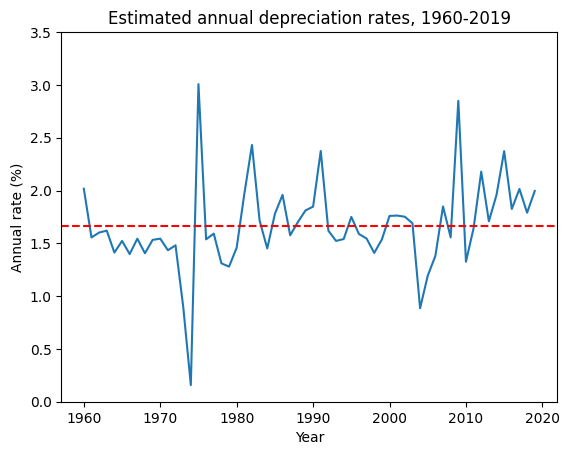

In [16]:
dates_trunc = pd.to_datetime([year for year in range(1960, 2020)], format = '%Y')
depr_trunc_df = pd.DataFrame(data = depr_trunc * 100)
depr_trunc_df = depr_trunc_df.set_index(dates_trunc)

plt.plot(depr_trunc_df)
plt.ylim([0, 3.5])
plt.xlabel('Year')
plt.ylabel('Annual rate (%)')
plt.title('Estimated annual depreciation rates, 1960-2019')
plt.axhline(y = np.mean(depr_trunc) * 100, color = 'r', linestyle = '--')
plt.show()

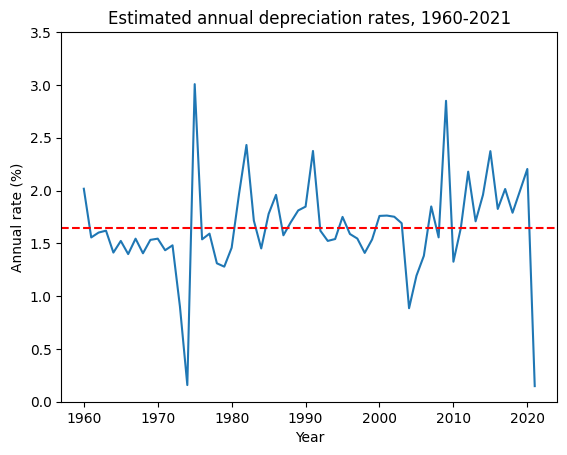

In [17]:
dates = pd.to_datetime([year for year in range(1960, 2022)], format = '%Y')
depr_df = pd.DataFrame(data = depr * 100)
depr_df = depr_df.set_index(dates)

plt.plot(depr_df)
plt.ylim([0, 3.5])
plt.xlabel('Year')
plt.ylabel('Annual rate (%)')
plt.title('Estimated annual depreciation rates, 1960-2021')
plt.axhline(y = np.mean(depr) * 100, color = 'r', linestyle = '--')
plt.show()

### Part 4

In [18]:
# for national income, use NICUR; for employee compensation, use COE

# 1959Q1 to 2019Q4
emp_comp_trunc = fred.get_series('COE', observation_start = '1959-01-01', observation_end = '2019-10-01')
nat_inc_trunc = fred.get_series('NICUR', observation_start = '1959-01-01', observation_end = '2019-10-01')

# 1959Q1 to 2021Q4
emp_comp = fred.get_series('COE', observation_start = '1959-01-01', observation_end = '2021-10-01')
nat_inc = fred.get_series('NICUR', observation_start = '1959-01-01', observation_end = '2021-10-01')

In [19]:
labor_share_trunc = emp_comp_trunc / nat_inc_trunc
labor_share = emp_comp / nat_inc

print('mean:', round(np.mean(labor_share_trunc), 4), 
      '\nmin:', round(np.min(labor_share_trunc), 4), 
      '\nmax:', round(np.max(labor_share_trunc), 4))
print()
print('mean:', round(np.mean(labor_share), 4), 
      '\nmin:', round(np.min(labor_share), 4), 
      '\nmax:', round(np.max(labor_share), 4))

mean: 0.6432 
min: 0.6022 
max: 0.6787

mean: 0.6431 
min: 0.6022 
max: 0.6787


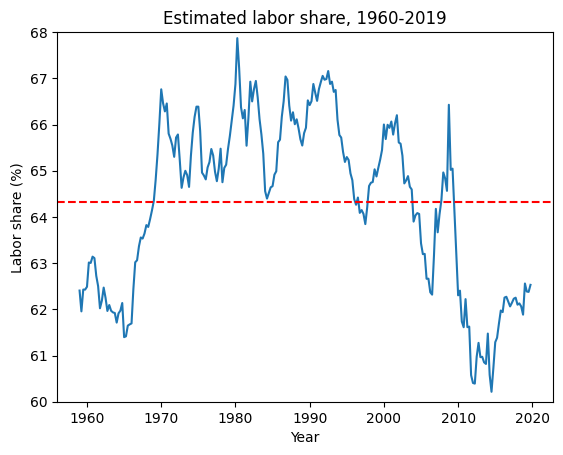

In [20]:
plt.plot(labor_share_trunc * 100)
plt.ylim([60, 68])
plt.xlabel('Year')
plt.ylabel('Labor share (%)')
plt.title('Estimated labor share, 1960-2019')
plt.axhline(y = np.mean(labor_share_trunc) * 100, color = 'r', linestyle = '--')
plt.show()

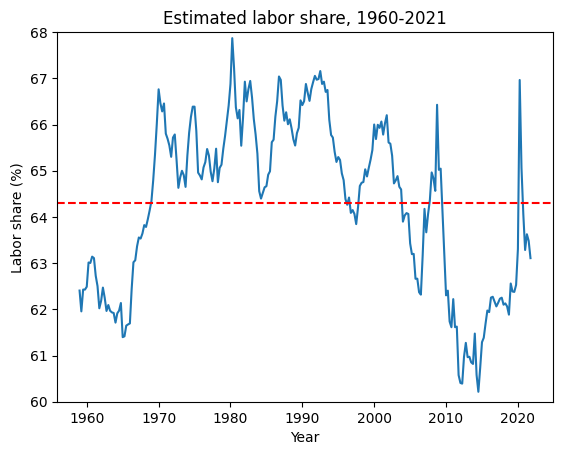

In [21]:
plt.plot(labor_share * 100)
plt.ylim([60, 68])
plt.xlabel('Year')
plt.ylabel('Labor share (%)')
plt.title('Estimated labor share, 1960-2021')
plt.axhline(y = np.mean(labor_share) * 100, color = 'r', linestyle = '--')
plt.show()

### Part 5

In [22]:
# capital share
alpha = 0.33

# Y and N start in 1959Q1, but we need to cut until 1960Q2 because K starts in 1960Q1
Y_pt, Y_p = Y_private_trunc[5:], Y_private[5:]
N_pt, N_p = N_private_trunc[5:], N_private[5:]

# because K is lagged, need to cut off at 2019/21Q4
K_qt, K_q = Kq_trunc[:-1], Kq[:-1]

# 1960Q2 to 2019Q4
log_A_trunc = np.zeros(len(K_qt))
for i in range(len(K_qt)):
    log_A_trunc[i] = np.log(Y_pt[i]) - alpha * np.log(K_qt[i]) - (1 - alpha) * np.log(N_pt[i])

# 1960Q2 to 2021Q4
log_A = np.zeros(len(K_q))
for i in range(len(K_q)):
    log_A[i] = np.log(Y_p[i]) - alpha * np.log(K_q[i]) - (1 - alpha) * np.log(N_p[i])

# detrend
A_trunc = hpfilter(log_A_trunc * 100, lamb = 1600)[0]
A = hpfilter(log_A * 100, lamb = 1600)[0]

In [23]:
# standard deviation
print('A_trunc:', round(np.std(A_trunc), 4), 
      '\nA:', round(np.std(A), 4))

A_trunc: 1.8044 
A: 1.8492


In [24]:
# relative standard deviation with respect to output
print('A_trunc:', round(np.std(A_trunc) / stdev_trunc['Y_trunc'], 4), 
      '\nA:', round(np.std(A) / stdev['Y'], 4))

A_trunc: 1.2613 
A: 1.1906


In [25]:
# first-order autocorrelation
print('A_trunc:', round(np.corrcoef(A_trunc[1:], A_trunc[0:-1])[0, 1], 4), 
      '\nA:', round(np.corrcoef(A[1:], A[0:-1])[0, 1], 4))

A_trunc: 0.8294 
A: 0.7897


In [26]:
# contemporaneous correlation with output
print('A_trunc:', round(np.corrcoef(A_trunc,  output_trunc['Y_trunc'][5:])[0, 1], 4), 
      '\nA:', round(np.corrcoef(A, output['Y'][5:])[0, 1], 4))

A_trunc: 0.7663 
A: 0.7645


### Part 6

In [27]:
# import data from excel file - just date and dtfp_util columns
df = pd.read_excel('quarterly_tfp.xlsx', sheet_name = 'quarterly', header = 1,
                   index_col = 0, skiprows = range(306, 312))

# 1960Q2 to 2019Q4 (adjustment as described in paper)
tfp_trunc = np.cumsum(df['dtfp_util']['1960:Q2':'2019:Q4']) / 400

# 1960Q2 to 2021Q4 (adjustment as described in paper)
tfp = np.cumsum(df['dtfp_util']['1960:Q2':'2021:Q4']) / 400

# use A[0] from part 5 as starting value for series
A_star_trunc = np.exp(log_A_trunc[0]) * np.exp(tfp_trunc)
A_star = np.exp(log_A[0]) * np.exp(tfp)

# detrend
A_star_trunc_hp = hpfilter(np.log(A_star_trunc) * 100, lamb = 1600)[0]
A_star_hp = hpfilter(np.log(A_star) * 100, lamb = 1600)[0]

In [28]:
# standard deviation
print('A_star_trunc:', round(np.std(A_star_trunc_hp), 4), 
      '\nA_star:', round(np.std(A_star_hp), 4))

A_star_trunc: 0.9259 
A_star: 0.9186


In [29]:
# relative standard deviation with respect to output
print('A_star_trunc:', round(np.std(A_star_trunc_hp) / stdev_trunc['Y_trunc'], 4), 
      '\nA_star:', round(np.std(A_star_hp) / stdev['Y'], 4))

A_star_trunc: 0.6472 
A_star: 0.5914


In [30]:
# first-order autocorrelation
print('A_star_trunc:', round(np.corrcoef(A_star_trunc_hp[1:], A_star_trunc_hp[0:-1])[0, 1], 4), 
      '\nA_star:', round(np.corrcoef(A_star_hp[1:], A_star_hp[0:-1])[0, 1], 4))

A_star_trunc: 0.6531 
A_star: 0.6475


In [31]:
# contemporaneous correlation with output
print('A_star_trunc:', round(np.corrcoef(A_star_trunc_hp, output_trunc['Y_trunc'][5:])[0, 1], 4), 
      '\nA_star:', round(np.corrcoef(A_star_hp, output['Y'][5:])[0, 1], 4))

A_star_trunc: -0.0195 
A_star: -0.0633


# Question 2

### Part 1

In [ ]:
@simple
def firm(K, n, a, alpha, delta):    
    r = alpha * a * (K(-1) / n) ** (alpha-1) - delta
    w = (1 - alpha) * a * (K(-1) / n) ** alpha
    Y = a * K(-1) ** alpha * n ** (1 - alpha)
    return r, w, Y

@simple
def household(K, n, w, eis, frisch, b, delta):    
    C = (w / b / n ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, n, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * n
    
    capital_output_r = K/Y - 14.
    invest_output_r = I/Y - 0.25
    
    labor = n - 0.3333333
    
    return goods_mkt, euler, walras, capital_output_r, invest_output_r, labor

In [ ]:
sigma = 0.01
eps = np.random.normal(0, sigma, 200)

In [ ]:
rbc = create_model([household, firm, mkt_clearing], name="rbc_problem_input_a")

In [ ]:
from sequence_jacobian import drawdag

unknowns = ["K", "n"]
targets = ["euler", "goods_mkt"]
inputs = ["a"]

drawdag(rbc, inputs, unknowns, targets)

In [ ]:
# calibration: known parameter values
# unknowns: K, n, unknown paramenter values (b, beta, delta)
# targets: Euler equation, market-clearing condition, K/Y = 14, I/Y = 0.25, n = 1/3

calibration = {"eis": 0.5, "frisch": 1., "alpha": 0.33, "rho": 0.9, "a": 1.}
unknowns_ss = {"b": 0.9, "beta": 0.9,  "delta": 0.2, "K": 3., "n": 0.33}
targets_ss = {"goods_mkt": 0., "euler": 0., "capital_output_r": 0., "invest_output_r": 0., "labor": 0.}

ss = rbc.solve_steady_state(calibration, unknowns_ss, targets_ss, solver = "hybr")

In [ ]:
for key, value in ss.items():
    print(key, value)

In [ ]:
print(f"Goods market clearing: {ss['goods_mkt']},\nEuler equation: {ss['euler']},\nWalras: {ss['walras']}")

In [ ]:
unknowns = ['K', 'n']
targets = ['euler', 'goods_mkt']
inputs = ['a']

G = rbc.solve_jacobian(ss, unknowns, targets, inputs, T=200)

In [ ]:
T, impact, rho = 200, 0.01, 0.9
da = np.zeros((T, 2))
da[0, 0] = impact * ss['a']
da[:, 1] = impact * ss['a'] * rho**np.arange(T)

In [ ]:
var_list = ["Y", "n", "C", "I", "K", "w", "r"]

In [ ]:
for var in var_list:
    dVal = 100 * G[var]['a'] @ da / ss[var]
    plt.plot(dVal[:50, 1], linewidth=2.5)
    plt.title(f'{var} response to TFP shocks')
    plt.ylabel('% deviation from ss')
    plt.xlabel('quarters')
    plt.show()

### Part 2

First, let us construct a class to hold information about each simulation

In [ ]:
import math
PERIODS = 200
BURN = 50
IMPACT = impact
RHO = rho

class Economy():
    def __init__(self, g_matrix, steady_state):
        # Get impulse response matrix and steady state from toolbox
        self.g_matrix = g_matrix 
        self.steady_state = steady_state

        # Create a list of iid shocks
        self.epsilon_list = np.random.normal(0, IMPACT, PERIODS + BURN)
        self.burned_epsilons = self.epsilon_list[BURN:]

        # Generate list of as given epsilons
        self.a_list = self.convert_epsilons_to_as(self.epsilon_list)
        self.burned_as = self.a_list[BURN:]

        # Generate a list of das given as
        # Note: da_list[0] = None because there is no lag for period 0
        self.da_list = [None] + [self.a_list[i] - self.a_list[i-1] for i in range(1, PERIODS + BURN)]
        self.burned_das = self.da_list[BURN:]

        # Generate sequences for capital, consumption, output, and labor
        self.K_list = self.simulate_sequence('K')
        self.burned_Ks = self.K_list[BURN:]

        self.C_list = self.simulate_sequence('C')
        self.burned_Cs = self.C_list[BURN:]

        self.Y_list = self.simulate_sequence('Y')
        self.burned_Ys = self.Y_list[BURN:]

        self.n_list = self.simulate_sequence('n')
        self.burned_ns = self.n_list[BURN:]

        self.w_list = self.simulate_sequence('w')
        self.burned_ws = self.w_list[BURN:]

        self.r_list = self.simulate_sequence('r')
        self.burned_rs = self.r_list[BURN:]

        self.I_list = self.simulate_sequence('I')
        self.burned_Is = self.I_list[BURN:]

    def convert_epsilons_to_as(self, epsilon_list):
        """
        Given a sequence of iid normal shocks, generates an AR(1) process
        representing log of a. 
        """
        lna_list = np.zeros(PERIODS + BURN)
        lna_list[0] = self.steady_state['a']
        for i in range(1, PERIODS + BURN):
            lna_list[i] = lna_list[i-1] * RHO + epsilon_list[i]
        return [math.exp(lna) for lna in lna_list]
    
    def simulate_sequence(self, variable):
        """
        Given a variable, generates a sequence of values for that variable
        """
        sequence = np.zeros(PERIODS + BURN)
        sequence[0] = self.steady_state[variable]
        for i in range(1, PERIODS + BURN):
            sequence[i] = sequence[i-1] + self.g_matrix[variable]['a'][i-1] * self.da_list[i]
        return sequence
    
    # Now we do getters for the burned sequences
    def get_burned_Ks(self):
        return self.burned_Ks
    
    def get_burned_Cs(self):
        return self.burned_Cs
    
    def get_burned_Ys(self):
        return self.burned_Ys
    
    def get_burned_ns(self):
        return self.burned_ns
    
    def get_burned_as(self):
        return self.burned_as
    
    def get_burned_das(self):
        return self.burned_das
    
    def get_burned_epsilons(self):
        return self.burned_epsilons
    
    def get_burned_ws(self):
        return self.burned_ws
    
    def get_burned_rs(self):
        return self.burned_rs
    
    def get_burned_Is(self):
        return self.burned_Is
    
Economy(G, ss)

Now that we have our simulation class defined, we can generate 100 of them as desired

In [ ]:
simulations = []
for i in range(100):
    e = Economy(G, ss)
    simulations.append(e)